In [1]:
import pandas as pd
import rrcf
import datetime
import numpy as np
import sys 
#sys.path.append('..')
#sys.path.insert(0, '')
from helpers import nearest_after, optimal_fbeta, calculate_metrics, forest_to_dict
import seaborn as sns
import json

# Carga de datos

In [3]:
traffic_data = pd.read_csv('../data/sabmiller_data/SABM-COL-BAQ-MW-M-386781mod.csv')
traffic_data.head()

,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER
0,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000,8.716002,2.727267,2018-02-01 15:05:00,WAN,SABM,386781
1,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000,8.962334,2.200488,2018-02-01 15:10:00,WAN,SABM,386781
2,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000,7.607139,2.258869,2018-02-01 15:15:00,WAN,SABM,386781
3,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000,8.079257,4.980340,2018-02-01 15:20:00,WAN,SABM,386781
4,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000,9.069742,9.456425,2018-02-01 15:25:00,WAN,SABM,386781


In [4]:
traffic_data = traffic_data.loc[traffic_data.DE_INTERFACE  == "GigabitEthernet0/0"]
traffic_data.shape

(218411, 9)

In [5]:
incidents_filtered = pd.read_csv("../data/sabmiller_data/incidenciasSABM.csv")
incidents_filtered.head()

,TICKET_ID,SUBMIT_DATE,CLOSED_DATE,LAST_RESOLVED_DATE,SERVICE_TYPE,REPORTED_SOURCE_ID,PORTAL_TICKET_ID,SIGMA_TICKET_ID,SUBMITTER,LAST_MODIFICATION_DATE,...,BMC_TICKET_PENDING_DATE,INF2_HPD_OUTAGE_DURATION,REASON_OUTAGE,RFO_AVAILABLE,CI_NAME,CI_COUNTRY,CI_CITY,CI_ID_FAST,ADMIN_NUMBER,INSTANCEID
0,INC000000562210,2017-01-26 20:19:00,2017-01-27 20:15:00,2017-01-27 20:15:00,User Service Restoration,Direct Input,NaN,NaN,80244050,20190718190246,...,2.017013e+13,0,NaN,N,20140416-SITEMPLS-0000386781,Colombia,Barranquilla,NaN,20140416-SITEMPLS-0000386781,AGHAA5V0A57OPAOK49A9IQGQQWWWCC
1,INC000000564687,2017-02-02 17:07:00,2017-02-03 10:57:00,2017-02-02 20:44:00,User Service Restoration,Direct Input,NaN,NaN,80164415,20190718190246,...,NaN,0,REINICIO DE EQUIPO DE UK,N,20140416-SITEMPLS-0000386781,Colombia,Barranquilla,NaN,20140416-SITEMPLS-0000386781,AGHAA5V0A57O9AOKRISH8M8MMTDEQM
2,INC000000588712,2017-03-28 18:36:00,2017-03-29 17:35:00,2017-03-29 06:18:00,User Service Restoration,Direct Input,NaN,NaN,80244050,20190718190246,...,2.017033e+13,0,Se presentó falla en equipo Core RN-BQA-DEL Ju...,N,20140416-SITEMPLS-0000386781,Colombia,Barranquilla,NaN,20140416-SITEMPLS-0000386781,AGHAA5V0A57OPAON90EKDRSQ7BTJRN
3,INC000000655192,2017-07-06 17:34:00,2017-07-06 21:26:00,2017-07-06 21:06:00,User Service Restoration,Direct Input,NaN,NaN,80244050,20190718190246,...,NaN,180,Corte de Fibra OT 3526679.,N,20140416-SITEMPLS-0000386781,Colombia,Barranquilla,NaN,20140416-SITEMPLS-0000386781,AGHAA5V0A57OPAOSO3YJCYBKQOTQG9
4,INC000000713348,2017-09-20 21:43:00,2017-09-20 21:56:00,2017-09-20 21:56:00,User Service Restoration,Direct Input,NaN,NaN,mncsd.cnavm02,20190311081341,...,NaN,0,NaN,N,20140416-SITEMPLS-0000386781,Colombia,Barranquilla,NaN,20140416-SITEMPLS-0000386781,AGHAA5V0A57O9AOWL6DXAS8XV2V0KE


# Fase de entrenamiento 

In [36]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_INPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2018-10-01 00:00:00':'2018-12-31 23:55:00']
train_data = train_data[train_data != 0] 

In [37]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring

In [ ]:
test_data = traffic_series['2019-01-01 00:00:00':'2019-07-31 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

In [ ]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

In [ ]:
# Se puede guardar para su posterior uso
#avg_codisp_no_shingle.to_csv('../data/sabmiller_data/sabm_anomaly_score_ene_jul.csv', index = False)

# Fase de optimización del threshold

In [6]:
# Se podrían cargar desde un fichero las anomaly_scores necesarias
avg_codisp_no_shingle = pd.read_csv('../data/sabmiller_data/sabm_anomaly_score_ene_jul.csv')

In [7]:
# Nos quedamos con las fechas de test y transformamos a tipo datetime
traffic_data_test = traffic_data[(traffic_data['DT_MEASURE_DATETIME'] >= '2019-01-01 00:00:00') & (traffic_data['DT_MEASURE_DATETIME'] <= '2019-07-31 23:55:00')].copy()
traffic_dates_test = traffic_data_test.DT_MEASURE_DATETIME.values
traffic_dates_test = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in traffic_dates_test]

incidents_filtered.sort_values(by = 'SUBMIT_DATE', inplace = True)
submit_dates_test = list(filter(lambda x: (str(x) > '2019-01-01 00:00:00' and str(x) < '2019-07-31 23:55:00'), incidents_filtered.SUBMIT_DATE.values))
resolved_dates_test = list(filter(lambda x: (str(x) > '2019-01-01 00:00:00' and str(x) < '2019-07-31 23:55:00'), incidents_filtered.LAST_RESOLVED_DATE.values))

mapped_submit_dates = [nearest_after(traffic_dates_test, submit_date) for submit_date in submit_dates_test]
mapped_resolved_dates = [nearest_after(traffic_dates_test, resolved_date) for resolved_date in resolved_dates_test]

# Existen incidencias que se mapean al mismo instante. Las mapeamos manualmente al instante anterior también y eliminamos duplicados
# También hay dos incidencias que se referían a fallos en la red local. Las descartamos. 
mapped_submit_dates.append('2019-01-07 04:00:00')
mapped_submit_dates.append('2019-02-13 10:25:00')
mapped_submit_dates.remove('2019-02-07 08:45:00')
mapped_submit_dates.remove('2019-05-16 16:55:00')
mapped_submit_dates = list(set(mapped_submit_dates))
mapped_submit_dates = sorted(mapped_submit_dates)

# Eliminamos también las fechas de resolución de las incidencias descartadas anteriormente. 
mapped_resolved_dates.remove('2019-02-07 09:00:00')
mapped_resolved_dates.remove('2019-05-16 16:55:00')

# Se calculan las diferencias entre submit_dates y last_resolved_dates
differences_resolved_submit = [np.ceil((datetime.datetime.strptime(mapped_resolved_dates[i], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(mapped_submit_dates[i], '%Y-%m-%d %H:%M:%S')).total_seconds()/60/5) for i in range(len(mapped_resolved_dates))] # Diferencia en nº de intervalos de 5 min.

traffic_data_test['INCIDENT'] = 0.0
traffic_data_test.loc[traffic_data['DT_MEASURE_DATETIME'].isin(mapped_submit_dates), 'INCIDENT'] = 1.0
incidents = traffic_data_test.INCIDENT.values

anomaly_scores_50 = avg_codisp_no_shingle['Anomaly score'].values

In [28]:
prev_points = 2
initial_threshold = 0
last_threshold = 250
beta_value = 2
num_incidents = len(mapped_submit_dates)

best_threshold = optimal_fbeta(anomaly_scores_50, incidents, prev_points, differences_resolved_submit, initial_threshold, last_threshold, beta_value, num_incidents)
fp, fn, tp, recall, precision, f2_score = calculate_metrics(anomaly_scores_50, incidents, prev_points, best_threshold, differences_resolved_submit, beta_value, num_incidents)

In [29]:
print('El threshold óptimo es: {}'.format(best_threshold))
print('El número de alarmas es: {}'.format(fp))
print('El número incidencias no captadas es: {}'.format(fn))
print('El número de incidencias captadas es: {}'.format(tp))
print('La precisión es {} y el recall {}'.format(precision, recall))
print('La f2_score alcanzada es: {}'.format(f2_score))

El threshold óptimo es: 154.0
El número de alarmas es: 32
El número incidencias no captadas es: 14
El número de incidencias captadas es: 1
La precisión es 0.030303030303 y el recall 0.0666666666667
La f2_score alcanzada es: 0.0537634408602


En el caso de SABMiller ocurría que había un desfase de 2 horas aproximadamente entre las anomalías en el tráfico y el registro de las incidencias. Para conseguir unos resultados coherentes, se hace necesario ampliar el intervalo previo de contabilización de true positives:

In [30]:
prev_points = 24
initial_threshold = 0
last_threshold = 250
beta_value = 2
num_incidents = len(mapped_submit_dates)

best_threshold = optimal_fbeta(anomaly_scores_50, incidents, prev_points, differences_resolved_submit, initial_threshold, last_threshold, beta_value, num_incidents)
fp, fn, tp, recall, precision, f2_score = calculate_metrics(anomaly_scores_50, incidents, prev_points, best_threshold, differences_resolved_submit, beta_value, num_incidents)

In [31]:
print('El threshold óptimo es: {}'.format(best_threshold))
print('El número de alarmas es: {}'.format(fp))
print('El número incidencias no captadas es: {}'.format(fn))
print('El número de incidencias captadas es: {}'.format(tp))
print('La precisión es {} y el recall {}'.format(precision, recall))
print('La f2_score alcanzada es: {}'.format(f2_score))

El threshold óptimo es: 142.0
El número de alarmas es: 110
El número incidencias no captadas es: 6
El número de incidencias captadas es: 9
La precisión es 0.0756302521008 y el recall 0.6
La f2_score alcanzada es: 0.251396648045


# Threshold estadístico

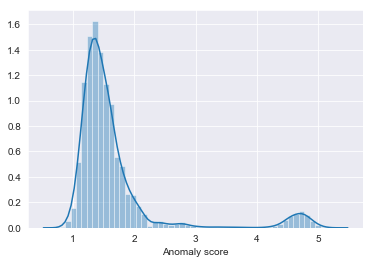

In [33]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

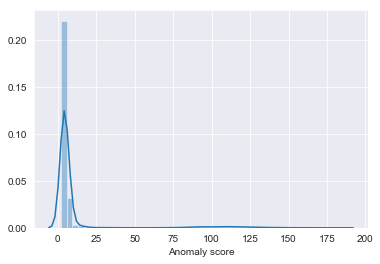

In [34]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [35]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

125.84

In [40]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["incident_threshold"] = best_threshold
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/bbva_usa_data/SABM-COL-BAQ-MW-M-386781_GigabitEthernet00_input.json', 'w') as output_file:
    json.dump(forest_dict, output_file)